In [1]:
# ============================================
# Cell 1 – Imports & Config
# ============================================
import os
import random
from dataclasses import dataclass
import math
import warnings

import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("../models", exist_ok=True)


@dataclass
class CFG:
    data_root: str = "../data/Train_Cropped"  # folder: subfolder per mahasiswa
    img_size: int = 160
    batch_size: int = 16
    num_workers: int = 0
    epochs: int = 50
    lr: float = 1e-4
    weight_decay: float = 1e-4
    label_smoothing: float = 0.0
    # ArcFace hyperparams
    arc_s: float = 25.0
    arc_m: float = 0.30  # 0.3 biasanya lebih stabil di dataset kecil
    val_ratio: float = 0.2
    seed: int = 32
    n_splits: int = 5


CFG = CFG()
print(CFG)


d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Tubes 2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
CFG(data_root='../data/Train_Cropped', img_size=160, batch_size=16, num_workers=0, epochs=50, lr=0.0001, weight_decay=0.0001, label_smoothing=0.0, arc_s=25.0, arc_m=0.3, val_ratio=0.2, seed=32, n_splits=5)


In [2]:
# ============================================
# Cell 2 – Fix Seed + Custom Aug Functions
# ============================================

def set_seed(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(CFG.seed)
print("Seed set to:", CFG.seed)


# -----------------------------
# CUSTOM FUNCTIONS
# -----------------------------
def add_gaussian_noise(img, std: float = 0.05):
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, std, arr.shape)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))


def add_multiplicative_noise(img, minv: float = 0.9, maxv: float = 1.1):
    arr = np.array(img).astype(np.float32) / 255.0
    mult = np.random.uniform(minv, maxv)
    arr = np.clip(arr * mult, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))


def iso_noise(img):
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 12, arr.shape) + np.random.normal(0, 2, arr.shape)
    arr = np.clip(arr + noise, 0, 255)
    return Image.fromarray(arr.astype(np.uint8))


def motion_blur(img, degree: int = 5):
    img_np = np.array(img)
    kernel = np.zeros((degree, degree), dtype=np.float32)
    kernel[int((degree - 1) / 2), :] = np.ones(degree, dtype=np.float32)
    kernel /= degree
    blurred = cv2.filter2D(img_np, -1, kernel)
    return Image.fromarray(blurred)


def random_shadow(img):
    w, h = img.size
    top_x = random.randint(0, w)
    top_y = 0
    bot_x = random.randint(0, w)
    bot_y = h

    mask = np.zeros((h, w), dtype=np.uint8)
    thickness = random.randint(30, 60)
    cv2.line(mask, (top_x, top_y), (bot_x, bot_y), 255, thickness=thickness)

    img_np = np.array(img).astype(np.float32)
    img_np[mask == 255] *= 0.6
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)

    return Image.fromarray(img_np)


def image_compression(img, quality: int = 60):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    _, enc = cv2.imencode(".jpg", img_bgr, encode_param)
    dec = cv2.imdecode(enc, 1)
    dec_rgb = cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dec_rgb)


Seed set to: 32


In [3]:
# ============================================
# Cell 3 – Dataset Scan, Transforms
# ============================================

class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


def scan_dataset(root_dir):
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]

    label_map = {cls_name: i for i, cls_name in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                fpath = os.path.join(cls_dir, fname)
                image_paths.append(fpath)
                labels.append(label_map[cls])

    print("Total classes:", len(classes))
    print("Total images :", len(image_paths))
    return image_paths, labels, label_map


# --- scan dataset ---
all_paths, all_labels, label_map = scan_dataset(CFG.data_root)

# --- transforms ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=20,
            translate=(0.10, 0.10),
            scale=(0.85, 1.15),
        )
    ], p=0.6),

    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.2)
    ], p=0.3),

    # “distortion” approximation
    transforms.RandomApply([
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1)))
    ], p=0.2),

    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1,
    ),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0)
    ], p=0.15),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 5))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: motion_blur(img, degree=5))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_gaussian_noise(img, std=0.05))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: iso_noise(img))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_multiplicative_noise(img, 0.9, 1.1))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: ImageEnhance.Brightness(img).enhance(0.8))
    ], p=0.3),

    transforms.RandomApply([
        transforms.Lambda(lambda img: random_shadow(img))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: image_compression(img, quality=random.randint(40, 80)))
    ], p=0.2),

    # ==== from PIL → Tensor ====
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),

    # ==== Tensor-based aug (RandomErasing) ====
    transforms.RandomErasing(
        p=0.3,
        scale=(0.02, 0.15),
        ratio=(0.3, 3.0),
        value="random",
    ),
])

val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

num_classes = len(label_map)
print("Final num_classes:", num_classes)


Total classes: 70
Total images : 283
Final num_classes: 70


In [4]:
# ============================================
# Cell 4 – ArcFace (ArcMarginProduct)
# ============================================

class ArcMarginProduct(nn.Module):
    """
    ArcFace: cos(theta + m) dengan scaling s.
    input: (B, in_features) -> embedding
    label: (B,) -> class index
    output: (B, out_features) -> logits untuk CrossEntropy
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float = 25.0,
        m: float = 0.10,
        easy_margin: bool = False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # normalize embedding dan weight
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine.pow(2), 0.0, 1.0))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        # ganti only target logit dengan phi, others tetap cosine
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [5]:
# ============================================
# Cell 5 – InceptionResnetV1 + ArcFace Model
# ============================================

class FaceNetArcFace(nn.Module):
    def __init__(self, num_classes: int, embedding_dim: int = 512,
                 s: float = 30.0, m: float = 0.30):
        super().__init__()

        # Backbone FaceNet pretrained di vggface2
        self.backbone = InceptionResnetV1(
            pretrained="vggface2",
            classify=False,  # keluaran embedding 512-dim
        )

        in_features = 512  # output dim InceptionResnetV1

        self.embedding = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

        self.arc_margin = ArcMarginProduct(
            in_features=embedding_dim,
            out_features=num_classes,
            s=s,
            m=m,
            easy_margin=False,
        )

    def forward(self, x, labels=None):
        feat = self.backbone(x)          # (B, 512)
        emb = self.embedding(feat)       # (B, 512)
        emb = F.normalize(emb, dim=1)

        if labels is None:
            # inference: pure cosine logits
            logits = F.linear(
                F.normalize(emb),
                F.normalize(self.arc_margin.weight),
            )
        else:
            # training: pakai ArcFace margin
            logits = self.arc_margin(emb, labels)

        return logits, emb


In [6]:
# ============================================
# Cell 6 – Loss, Optimizer & Scheduler Factory
# ============================================
from torch import amp

criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
print("Criterion:", criterion)


def create_model_optimizer_scheduler():
    """Factory: buat model, optimizer, scheduler (dipakai per-fold)."""
    model = FaceNetArcFace(
        num_classes=num_classes,
        embedding_dim=512,
        s=CFG.arc_s,
        m=CFG.arc_m,
    ).to(device)

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print("Trainable params:", sum(p.numel() for p in trainable_params))

    optimizer = torch.optim.Adam(
        trainable_params,
        lr=CFG.lr,
        weight_decay=CFG.weight_decay,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CFG.epochs,
        eta_min=CFG.lr * 1e-2,
    )

    return model, optimizer, scheduler


Criterion: CrossEntropyLoss()


In [7]:
# ============================================
# Cell 7 – Train & Val Loop (ArcFace)
# ============================================

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    all_preds, all_trues = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()

        with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(imgs, labels)  # pakai margin
            loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # pakai logits tanpa margin untuk hitung akurasi (lebih fair)
        with torch.no_grad():
            logits_plain, _ = model(imgs, labels=None)
            preds = logits_plain.argmax(1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=device)

            with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                logits, _ = model(imgs, labels=None)  # logits tanpa margin
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)

            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc, np.array(all_trues), np.array(all_preds)


In [8]:
# ============================================
# Cell 8 – Main Training Loop (5-Fold Stratified K-Fold)
# ============================================

all_paths_np = np.array(all_paths)
all_labels_np = np.array(all_labels)

skf = StratifiedKFold(
    n_splits=CFG.n_splits,
    shuffle=True,
    random_state=CFG.seed,
)

fold_best_accs = []
global_best_acc = 0.0
global_best_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths_np, all_labels_np), start=1):
    print("\n" + "=" * 50)
    print(f"========== Fold {fold}/{CFG.n_splits} ==========")
    print("=" * 50)

    # -----------------------------
    # Build paths & labels per fold
    # -----------------------------
    train_paths = all_paths_np[train_idx].tolist()
    train_labels = all_labels_np[train_idx].tolist()
    val_paths = all_paths_np[val_idx].tolist()
    val_labels = all_labels_np[val_idx].tolist()

    print(f"Fold {fold} – Train samples: {len(train_paths)}")
    print(f"Fold {fold} – Val samples  : {len(val_paths)}")

    # -----------------------------
    # Dataset & DataLoader per fold
    # -----------------------------
    train_dataset = FaceDataset(train_paths, train_labels, transform=train_tf)
    val_dataset   = FaceDataset(val_paths,   val_labels,   transform=val_tf)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    # -----------------------------
    # Model, optimizer, scheduler per fold
    # -----------------------------
    model, optimizer, scheduler = create_model_optimizer_scheduler()

    best_acc_fold = 0.0

    # -----------------------------
    # Epoch loop per fold
    # -----------------------------
    for epoch in range(1, CFG.epochs + 1):
        print(f"\n=== Fold {fold} | Epoch {epoch}/{CFG.epochs} ===")
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, val_loader)

        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # --- best per fold (optional, kalau mau simpan per-fold) ---
        if val_acc > best_acc_fold:
            best_acc_fold = val_acc
            print(f"🔥 New best model on FOLD {fold}! Val Acc = {best_acc_fold:.4f}")

        # --- best global (semua fold) ---
        if val_acc > global_best_acc:
            global_best_acc = val_acc
            global_best_state = model.state_dict()   # <--- PERSIS gaya kamu
            print(f"💾 Update GLOBAL best! Val Acc = {global_best_acc:.4f}")

    print(f"\n>>> Fold {fold} finished. Best Val Acc (fold) = {best_acc_fold:.4f}")
    fold_best_accs.append(best_acc_fold)

print("\n" + "=" * 50)
print("K-Fold training complete.")
print("Per-fold best accuracies:", [float(a) for a in fold_best_accs])
print(f"Global best Val Acc across folds: {float(global_best_acc):.4f}")
print("=" * 50)

# -----------------------------
# Save best model across all folds (murni state_dict)
# -----------------------------
if global_best_state is not None:
    save_path = os.path.join("../models", "best_facenet_arcface_kfold5.pth")
    torch.save(global_best_state, save_path)
    print(f"Best model (across folds) saved to {save_path}")



========== Fold 1/5 ==========
Fold 1 – Train samples: 226
Fold 1 – Val samples  : 57
Trainable params: 28208823

=== Fold 1 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 12.0495 | Train Acc: 0.0531
Val   Loss: 4.2301 | Val   Acc: 0.0526
🔥 New best model on FOLD 1! Val Acc = 0.0526
💾 Update GLOBAL best! Val Acc = 0.0526

=== Fold 1 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.4789 | Train Acc: 0.1150
Val   Loss: 4.2057 | Val   Acc: 0.1053
🔥 New best model on FOLD 1! Val Acc = 0.1053
💾 Update GLOBAL best! Val Acc = 0.1053

=== Fold 1 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1065 | Train Acc: 0.1504
Val   Loss: 4.1789 | Val   Acc: 0.2982
🔥 New best model on FOLD 1! Val Acc = 0.2982
💾 Update GLOBAL best! Val Acc = 0.2982

=== Fold 1 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 10.6861 | Train Acc: 0.2522
Val   Loss: 4.1745 | Val   Acc: 0.3684
🔥 New best model on FOLD 1! Val Acc = 0.3684
💾 Update GLOBAL best! Val Acc = 0.3684

=== Fold 1 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.5758 | Train Acc: 0.2699
Val   Loss: 4.1563 | Val   Acc: 0.4386
🔥 New best model on FOLD 1! Val Acc = 0.4386
💾 Update GLOBAL best! Val Acc = 0.4386

=== Fold 1 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.1156 | Train Acc: 0.4381
Val   Loss: 4.1394 | Val   Acc: 0.5965
🔥 New best model on FOLD 1! Val Acc = 0.5965
💾 Update GLOBAL best! Val Acc = 0.5965

=== Fold 1 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.0751 | Train Acc: 0.4336
Val   Loss: 4.1250 | Val   Acc: 0.5614

=== Fold 1 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 9.7373 | Train Acc: 0.5664
Val   Loss: 4.1240 | Val   Acc: 0.5439

=== Fold 1 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 9.6097 | Train Acc: 0.5885
Val   Loss: 4.1069 | Val   Acc: 0.6316
🔥 New best model on FOLD 1! Val Acc = 0.6316
💾 Update GLOBAL best! Val Acc = 0.6316

=== Fold 1 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 9.2491 | Train Acc: 0.6150
Val   Loss: 4.0949 | Val   Acc: 0.7193
🔥 New best model on FOLD 1! Val Acc = 0.7193
💾 Update GLOBAL best! Val Acc = 0.7193

=== Fold 1 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 8.9096 | Train Acc: 0.6991
Val   Loss: 4.0832 | Val   Acc: 0.7193

=== Fold 1 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 8.7478 | Train Acc: 0.7168
Val   Loss: 4.0711 | Val   Acc: 0.7368
🔥 New best model on FOLD 1! Val Acc = 0.7368
💾 Update GLOBAL best! Val Acc = 0.7368

=== Fold 1 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 8.6995 | Train Acc: 0.7434
Val   Loss: 4.0612 | Val   Acc: 0.7544
🔥 New best model on FOLD 1! Val Acc = 0.7544
💾 Update GLOBAL best! Val Acc = 0.7544

=== Fold 1 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 8.4615 | Train Acc: 0.7743
Val   Loss: 4.0601 | Val   Acc: 0.7193

=== Fold 1 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 8.2944 | Train Acc: 0.7788
Val   Loss: 4.0486 | Val   Acc: 0.7544

=== Fold 1 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 8.0102 | Train Acc: 0.8407
Val   Loss: 4.0362 | Val   Acc: 0.8246
🔥 New best model on FOLD 1! Val Acc = 0.8246
💾 Update GLOBAL best! Val Acc = 0.8246

=== Fold 1 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 7.8804 | Train Acc: 0.8496
Val   Loss: 4.0287 | Val   Acc: 0.8246

=== Fold 1 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 7.8635 | Train Acc: 0.8673
Val   Loss: 4.0211 | Val   Acc: 0.8070

=== Fold 1 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 7.5943 | Train Acc: 0.9159
Val   Loss: 4.0172 | Val   Acc: 0.7719

=== Fold 1 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 7.4977 | Train Acc: 0.8850
Val   Loss: 4.0141 | Val   Acc: 0.7895

=== Fold 1 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 7.1849 | Train Acc: 0.9469
Val   Loss: 4.0046 | Val   Acc: 0.7719

=== Fold 1 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 7.1943 | Train Acc: 0.9292
Val   Loss: 3.9959 | Val   Acc: 0.8246

=== Fold 1 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 6.9841 | Train Acc: 0.9248
Val   Loss: 3.9904 | Val   Acc: 0.7895

=== Fold 1 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 6.8726 | Train Acc: 0.9646
Val   Loss: 3.9799 | Val   Acc: 0.8246

=== Fold 1 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 6.7673 | Train Acc: 0.9336
Val   Loss: 3.9760 | Val   Acc: 0.8246

=== Fold 1 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 6.6280 | Train Acc: 0.9558
Val   Loss: 3.9670 | Val   Acc: 0.8070

=== Fold 1 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 6.3545 | Train Acc: 0.9690
Val   Loss: 3.9608 | Val   Acc: 0.8421
🔥 New best model on FOLD 1! Val Acc = 0.8421
💾 Update GLOBAL best! Val Acc = 0.8421

=== Fold 1 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 6.3319 | Train Acc: 0.9646
Val   Loss: 3.9754 | Val   Acc: 0.7544

=== Fold 1 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 6.2144 | Train Acc: 0.9381
Val   Loss: 3.9583 | Val   Acc: 0.8421

=== Fold 1 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 6.1373 | Train Acc: 0.9558
Val   Loss: 3.9538 | Val   Acc: 0.8246

=== Fold 1 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 6.0815 | Train Acc: 0.9779
Val   Loss: 3.9640 | Val   Acc: 0.8421

=== Fold 1 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 5.8900 | Train Acc: 0.9779
Val   Loss: 3.9446 | Val   Acc: 0.8421

=== Fold 1 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 5.8804 | Train Acc: 0.9867
Val   Loss: 3.9396 | Val   Acc: 0.8596
🔥 New best model on FOLD 1! Val Acc = 0.8596
💾 Update GLOBAL best! Val Acc = 0.8596

=== Fold 1 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 5.7987 | Train Acc: 0.9823
Val   Loss: 3.9375 | Val   Acc: 0.8596

=== Fold 1 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 5.7030 | Train Acc: 0.9735
Val   Loss: 3.9390 | Val   Acc: 0.8421

=== Fold 1 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 5.8299 | Train Acc: 0.9779
Val   Loss: 3.9678 | Val   Acc: 0.7719

=== Fold 1 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 5.8107 | Train Acc: 0.9779
Val   Loss: 3.9286 | Val   Acc: 0.8772
🔥 New best model on FOLD 1! Val Acc = 0.8772
💾 Update GLOBAL best! Val Acc = 0.8772

=== Fold 1 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 5.6492 | Train Acc: 0.9779
Val   Loss: 3.9318 | Val   Acc: 0.8772

=== Fold 1 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 5.7147 | Train Acc: 0.9602
Val   Loss: 3.9252 | Val   Acc: 0.8772

=== Fold 1 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 5.5140 | Train Acc: 0.9823
Val   Loss: 3.9232 | Val   Acc: 0.8596

=== Fold 1 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 5.5417 | Train Acc: 0.9823
Val   Loss: 3.9234 | Val   Acc: 0.8596

=== Fold 1 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 5.5628 | Train Acc: 0.9823
Val   Loss: 3.9236 | Val   Acc: 0.8596

=== Fold 1 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 5.4541 | Train Acc: 0.9735
Val   Loss: 3.9201 | Val   Acc: 0.8596

=== Fold 1 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 5.4543 | Train Acc: 0.9823
Val   Loss: 3.9251 | Val   Acc: 0.8246

=== Fold 1 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 5.5301 | Train Acc: 0.9912
Val   Loss: 3.9185 | Val   Acc: 0.8772

=== Fold 1 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 5.3926 | Train Acc: 0.9735
Val   Loss: 3.9241 | Val   Acc: 0.8772

=== Fold 1 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 5.3272 | Train Acc: 0.9823
Val   Loss: 3.9191 | Val   Acc: 0.8596

=== Fold 1 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 5.4441 | Train Acc: 0.9690
Val   Loss: 3.9260 | Val   Acc: 0.8421

=== Fold 1 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 5.4698 | Train Acc: 0.9690
Val   Loss: 3.9203 | Val   Acc: 0.8947
🔥 New best model on FOLD 1! Val Acc = 0.8947
💾 Update GLOBAL best! Val Acc = 0.8947

=== Fold 1 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 5.4618 | Train Acc: 0.9912
Val   Loss: 3.9221 | Val   Acc: 0.8772

>>> Fold 1 finished. Best Val Acc (fold) = 0.8947

========== Fold 2/5 ==========
Fold 2 – Train samples: 226
Fold 2 – Val samples  : 57
Trainable params: 28208823

=== Fold 2 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 12.1578 | Train Acc: 0.0619
Val   Loss: 4.2311 | Val   Acc: 0.0877
🔥 New best model on FOLD 2! Val Acc = 0.0877

=== Fold 2 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.6396 | Train Acc: 0.0752
Val   Loss: 4.2120 | Val   Acc: 0.1579
🔥 New best model on FOLD 2! Val Acc = 0.1579

=== Fold 2 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.2319 | Train Acc: 0.1195
Val   Loss: 4.1926 | Val   Acc: 0.2105
🔥 New best model on FOLD 2! Val Acc = 0.2105

=== Fold 2 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 10.8937 | Train Acc: 0.1991
Val   Loss: 4.1744 | Val   Acc: 0.3333
🔥 New best model on FOLD 2! Val Acc = 0.3333

=== Fold 2 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.5770 | Train Acc: 0.2257
Val   Loss: 4.1582 | Val   Acc: 0.4211
🔥 New best model on FOLD 2! Val Acc = 0.4211

=== Fold 2 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.2967 | Train Acc: 0.3496
Val   Loss: 4.1464 | Val   Acc: 0.4386
🔥 New best model on FOLD 2! Val Acc = 0.4386

=== Fold 2 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 9.9492 | Train Acc: 0.4381
Val   Loss: 4.1343 | Val   Acc: 0.5263
🔥 New best model on FOLD 2! Val Acc = 0.5263

=== Fold 2 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 9.8641 | Train Acc: 0.5044
Val   Loss: 4.1282 | Val   Acc: 0.5614
🔥 New best model on FOLD 2! Val Acc = 0.5614

=== Fold 2 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 9.6267 | Train Acc: 0.5177
Val   Loss: 4.1114 | Val   Acc: 0.5439

=== Fold 2 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 9.4296 | Train Acc: 0.5796
Val   Loss: 4.1020 | Val   Acc: 0.6316
🔥 New best model on FOLD 2! Val Acc = 0.6316

=== Fold 2 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 9.2167 | Train Acc: 0.6018
Val   Loss: 4.0936 | Val   Acc: 0.6140

=== Fold 2 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 8.9185 | Train Acc: 0.6549
Val   Loss: 4.0803 | Val   Acc: 0.7018
🔥 New best model on FOLD 2! Val Acc = 0.7018

=== Fold 2 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 8.6887 | Train Acc: 0.7212
Val   Loss: 4.0642 | Val   Acc: 0.7719
🔥 New best model on FOLD 2! Val Acc = 0.7719

=== Fold 2 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 8.5978 | Train Acc: 0.7345
Val   Loss: 4.0587 | Val   Acc: 0.7719

=== Fold 2 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 8.3181 | Train Acc: 0.7832
Val   Loss: 4.0503 | Val   Acc: 0.7018

=== Fold 2 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 8.1236 | Train Acc: 0.8363
Val   Loss: 4.0379 | Val   Acc: 0.7368

=== Fold 2 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 8.0663 | Train Acc: 0.8496
Val   Loss: 4.0309 | Val   Acc: 0.7544

=== Fold 2 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 7.8747 | Train Acc: 0.8363
Val   Loss: 4.0244 | Val   Acc: 0.8070
🔥 New best model on FOLD 2! Val Acc = 0.8070

=== Fold 2 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 7.6690 | Train Acc: 0.8805
Val   Loss: 4.0170 | Val   Acc: 0.7895

=== Fold 2 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 7.5733 | Train Acc: 0.8761
Val   Loss: 4.0183 | Val   Acc: 0.7368

=== Fold 2 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 7.4023 | Train Acc: 0.9159
Val   Loss: 4.0059 | Val   Acc: 0.7544

=== Fold 2 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 7.3091 | Train Acc: 0.8982
Val   Loss: 3.9980 | Val   Acc: 0.8070

=== Fold 2 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 7.1568 | Train Acc: 0.9292
Val   Loss: 3.9993 | Val   Acc: 0.7719

=== Fold 2 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 7.0146 | Train Acc: 0.8938
Val   Loss: 3.9880 | Val   Acc: 0.7719

=== Fold 2 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 6.8689 | Train Acc: 0.9115
Val   Loss: 3.9837 | Val   Acc: 0.8070

=== Fold 2 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 6.6891 | Train Acc: 0.9469
Val   Loss: 3.9829 | Val   Acc: 0.7895

=== Fold 2 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 6.6181 | Train Acc: 0.9469
Val   Loss: 3.9769 | Val   Acc: 0.7719

=== Fold 2 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 6.4870 | Train Acc: 0.9469
Val   Loss: 3.9662 | Val   Acc: 0.8246
🔥 New best model on FOLD 2! Val Acc = 0.8246

=== Fold 2 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 6.3312 | Train Acc: 0.9469
Val   Loss: 3.9590 | Val   Acc: 0.8596
🔥 New best model on FOLD 2! Val Acc = 0.8596

=== Fold 2 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 6.2161 | Train Acc: 0.9779
Val   Loss: 3.9574 | Val   Acc: 0.8246

=== Fold 2 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 6.1971 | Train Acc: 0.9646
Val   Loss: 3.9490 | Val   Acc: 0.8596

=== Fold 2 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 6.1246 | Train Acc: 0.9735
Val   Loss: 3.9499 | Val   Acc: 0.8772
🔥 New best model on FOLD 2! Val Acc = 0.8772

=== Fold 2 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 6.1071 | Train Acc: 0.9823
Val   Loss: 3.9475 | Val   Acc: 0.8596

=== Fold 2 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 5.9739 | Train Acc: 0.9690
Val   Loss: 3.9447 | Val   Acc: 0.8596

=== Fold 2 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 6.0674 | Train Acc: 0.9558
Val   Loss: 3.9388 | Val   Acc: 0.8947
🔥 New best model on FOLD 2! Val Acc = 0.8947

=== Fold 2 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 5.9844 | Train Acc: 0.9602
Val   Loss: 3.9372 | Val   Acc: 0.8596

=== Fold 2 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 5.8877 | Train Acc: 0.9558
Val   Loss: 3.9302 | Val   Acc: 0.8947

=== Fold 2 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 5.8464 | Train Acc: 0.9690
Val   Loss: 3.9315 | Val   Acc: 0.9123
🔥 New best model on FOLD 2! Val Acc = 0.9123
💾 Update GLOBAL best! Val Acc = 0.9123

=== Fold 2 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 5.6514 | Train Acc: 0.9646
Val   Loss: 3.9280 | Val   Acc: 0.8947

=== Fold 2 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 5.7592 | Train Acc: 0.9823
Val   Loss: 3.9324 | Val   Acc: 0.9123

=== Fold 2 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 5.6366 | Train Acc: 0.9867
Val   Loss: 3.9281 | Val   Acc: 0.8947

=== Fold 2 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 5.6187 | Train Acc: 0.9602
Val   Loss: 3.9299 | Val   Acc: 0.8596

=== Fold 2 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 5.6251 | Train Acc: 0.9956
Val   Loss: 3.9295 | Val   Acc: 0.8772

=== Fold 2 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 5.6860 | Train Acc: 0.9558
Val   Loss: 3.9246 | Val   Acc: 0.8772

=== Fold 2 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 5.6171 | Train Acc: 0.9912
Val   Loss: 3.9230 | Val   Acc: 0.8772

=== Fold 2 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 5.6461 | Train Acc: 0.9867
Val   Loss: 3.9280 | Val   Acc: 0.8772

=== Fold 2 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 5.5630 | Train Acc: 0.9735
Val   Loss: 3.9222 | Val   Acc: 0.8947

=== Fold 2 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 5.5193 | Train Acc: 0.9823
Val   Loss: 3.9286 | Val   Acc: 0.8772

=== Fold 2 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 5.6141 | Train Acc: 0.9469
Val   Loss: 3.9195 | Val   Acc: 0.8947

=== Fold 2 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 5.5640 | Train Acc: 0.9690
Val   Loss: 3.9234 | Val   Acc: 0.8772

>>> Fold 2 finished. Best Val Acc (fold) = 0.9123

========== Fold 3/5 ==========
Fold 3 – Train samples: 226
Fold 3 – Val samples  : 57
Trainable params: 28208823

=== Fold 3 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.9237 | Train Acc: 0.0310
Val   Loss: 4.2135 | Val   Acc: 0.0351
🔥 New best model on FOLD 3! Val Acc = 0.0351

=== Fold 3 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.3547 | Train Acc: 0.0973
Val   Loss: 4.1933 | Val   Acc: 0.2982
🔥 New best model on FOLD 3! Val Acc = 0.2982

=== Fold 3 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.0519 | Train Acc: 0.1770
Val   Loss: 4.1787 | Val   Acc: 0.3860
🔥 New best model on FOLD 3! Val Acc = 0.3860

=== Fold 3 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 10.8112 | Train Acc: 0.2920
Val   Loss: 4.1635 | Val   Acc: 0.4561
🔥 New best model on FOLD 3! Val Acc = 0.4561

=== Fold 3 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.4442 | Train Acc: 0.3009
Val   Loss: 4.1465 | Val   Acc: 0.5789
🔥 New best model on FOLD 3! Val Acc = 0.5789

=== Fold 3 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.2221 | Train Acc: 0.3894
Val   Loss: 4.1330 | Val   Acc: 0.7368
🔥 New best model on FOLD 3! Val Acc = 0.7368

=== Fold 3 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 9.8955 | Train Acc: 0.4912
Val   Loss: 4.1210 | Val   Acc: 0.7368

=== Fold 3 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 9.6652 | Train Acc: 0.4956
Val   Loss: 4.1084 | Val   Acc: 0.7719
🔥 New best model on FOLD 3! Val Acc = 0.7719

=== Fold 3 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 9.5432 | Train Acc: 0.5841
Val   Loss: 4.0992 | Val   Acc: 0.7193

=== Fold 3 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 9.1427 | Train Acc: 0.6814
Val   Loss: 4.0834 | Val   Acc: 0.7895
🔥 New best model on FOLD 3! Val Acc = 0.7895

=== Fold 3 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 9.0643 | Train Acc: 0.6726
Val   Loss: 4.0759 | Val   Acc: 0.8070
🔥 New best model on FOLD 3! Val Acc = 0.8070

=== Fold 3 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 8.8000 | Train Acc: 0.8053
Val   Loss: 4.0587 | Val   Acc: 0.8772
🔥 New best model on FOLD 3! Val Acc = 0.8772

=== Fold 3 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 8.5622 | Train Acc: 0.7699
Val   Loss: 4.0462 | Val   Acc: 0.8772

=== Fold 3 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 8.5367 | Train Acc: 0.7965
Val   Loss: 4.0429 | Val   Acc: 0.8421

=== Fold 3 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 8.2850 | Train Acc: 0.8673
Val   Loss: 4.0303 | Val   Acc: 0.8772

=== Fold 3 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 8.0049 | Train Acc: 0.8540
Val   Loss: 4.0239 | Val   Acc: 0.9123
🔥 New best model on FOLD 3! Val Acc = 0.9123

=== Fold 3 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 7.8449 | Train Acc: 0.8894
Val   Loss: 4.0104 | Val   Acc: 0.8947

=== Fold 3 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 7.7645 | Train Acc: 0.8761
Val   Loss: 4.0084 | Val   Acc: 0.8596

=== Fold 3 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 7.6281 | Train Acc: 0.9027
Val   Loss: 3.9959 | Val   Acc: 0.8772

=== Fold 3 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 7.4832 | Train Acc: 0.9292
Val   Loss: 3.9890 | Val   Acc: 0.9123

=== Fold 3 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 7.2258 | Train Acc: 0.9204
Val   Loss: 3.9822 | Val   Acc: 0.8947

=== Fold 3 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 7.0584 | Train Acc: 0.9513
Val   Loss: 3.9700 | Val   Acc: 0.9298
🔥 New best model on FOLD 3! Val Acc = 0.9298
💾 Update GLOBAL best! Val Acc = 0.9298

=== Fold 3 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 7.1052 | Train Acc: 0.9558
Val   Loss: 3.9647 | Val   Acc: 0.8947

=== Fold 3 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 6.8265 | Train Acc: 0.9602
Val   Loss: 3.9613 | Val   Acc: 0.8772

=== Fold 3 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 6.9310 | Train Acc: 0.9425
Val   Loss: 3.9550 | Val   Acc: 0.9123

=== Fold 3 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 6.5900 | Train Acc: 0.9558
Val   Loss: 3.9513 | Val   Acc: 0.9298

=== Fold 3 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 6.4956 | Train Acc: 0.9646
Val   Loss: 3.9424 | Val   Acc: 0.9123

=== Fold 3 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 6.3957 | Train Acc: 0.9646
Val   Loss: 3.9403 | Val   Acc: 0.8947

=== Fold 3 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 6.2514 | Train Acc: 0.9735
Val   Loss: 3.9417 | Val   Acc: 0.9298

=== Fold 3 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 6.1345 | Train Acc: 0.9867
Val   Loss: 3.9318 | Val   Acc: 0.8947

=== Fold 3 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 6.2448 | Train Acc: 0.9690
Val   Loss: 3.9352 | Val   Acc: 0.9123

=== Fold 3 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 6.1472 | Train Acc: 0.9779
Val   Loss: 3.9197 | Val   Acc: 0.9649
🔥 New best model on FOLD 3! Val Acc = 0.9649
💾 Update GLOBAL best! Val Acc = 0.9649

=== Fold 3 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 5.8796 | Train Acc: 0.9690
Val   Loss: 3.9152 | Val   Acc: 0.9649

=== Fold 3 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 5.8657 | Train Acc: 0.9823
Val   Loss: 3.9150 | Val   Acc: 0.9123

=== Fold 3 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 5.8758 | Train Acc: 0.9690
Val   Loss: 3.9154 | Val   Acc: 0.9123

=== Fold 3 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 5.7511 | Train Acc: 0.9735
Val   Loss: 3.9083 | Val   Acc: 0.9474

=== Fold 3 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 5.7395 | Train Acc: 0.9779
Val   Loss: 3.9058 | Val   Acc: 0.9474

=== Fold 3 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 5.7236 | Train Acc: 0.9602
Val   Loss: 3.9066 | Val   Acc: 0.9649

=== Fold 3 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 5.6129 | Train Acc: 0.9912
Val   Loss: 3.9055 | Val   Acc: 0.9474

=== Fold 3 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 5.5388 | Train Acc: 0.9779
Val   Loss: 3.9028 | Val   Acc: 0.9474

=== Fold 3 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 5.6873 | Train Acc: 0.9779
Val   Loss: 3.9010 | Val   Acc: 0.9474

=== Fold 3 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 5.6209 | Train Acc: 0.9912
Val   Loss: 3.9014 | Val   Acc: 0.9474

=== Fold 3 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 5.4917 | Train Acc: 0.9867
Val   Loss: 3.9029 | Val   Acc: 0.9298

=== Fold 3 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 5.5370 | Train Acc: 0.9912
Val   Loss: 3.9048 | Val   Acc: 0.9474

=== Fold 3 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 5.4899 | Train Acc: 0.9779
Val   Loss: 3.8985 | Val   Acc: 0.9298

=== Fold 3 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 5.3938 | Train Acc: 0.9912
Val   Loss: 3.9008 | Val   Acc: 0.9298

=== Fold 3 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 5.3530 | Train Acc: 0.9867
Val   Loss: 3.9034 | Val   Acc: 0.9298

=== Fold 3 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 5.3672 | Train Acc: 0.9956
Val   Loss: 3.8950 | Val   Acc: 0.9474

=== Fold 3 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 5.3945 | Train Acc: 0.9867
Val   Loss: 3.9028 | Val   Acc: 0.9123

=== Fold 3 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 5.5242 | Train Acc: 0.9735
Val   Loss: 3.8956 | Val   Acc: 0.9474

>>> Fold 3 finished. Best Val Acc (fold) = 0.9649

========== Fold 4/5 ==========
Fold 4 – Train samples: 227
Fold 4 – Val samples  : 56
Trainable params: 28208823

=== Fold 4 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.9967 | Train Acc: 0.0441
Val   Loss: 4.2225 | Val   Acc: 0.0714
🔥 New best model on FOLD 4! Val Acc = 0.0714

=== Fold 4 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.4265 | Train Acc: 0.1013
Val   Loss: 4.1997 | Val   Acc: 0.2143
🔥 New best model on FOLD 4! Val Acc = 0.2143

=== Fold 4 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1452 | Train Acc: 0.1454
Val   Loss: 4.1793 | Val   Acc: 0.2679
🔥 New best model on FOLD 4! Val Acc = 0.2679

=== Fold 4 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 10.6653 | Train Acc: 0.2203
Val   Loss: 4.1661 | Val   Acc: 0.3393
🔥 New best model on FOLD 4! Val Acc = 0.3393

=== Fold 4 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.3258 | Train Acc: 0.2996
Val   Loss: 4.1523 | Val   Acc: 0.4286
🔥 New best model on FOLD 4! Val Acc = 0.4286

=== Fold 4 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.1196 | Train Acc: 0.4405
Val   Loss: 4.1367 | Val   Acc: 0.5536
🔥 New best model on FOLD 4! Val Acc = 0.5536

=== Fold 4 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 9.7759 | Train Acc: 0.5330
Val   Loss: 4.1226 | Val   Acc: 0.5179

=== Fold 4 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 9.5744 | Train Acc: 0.5771
Val   Loss: 4.1050 | Val   Acc: 0.6250
🔥 New best model on FOLD 4! Val Acc = 0.6250

=== Fold 4 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 9.4157 | Train Acc: 0.6520
Val   Loss: 4.0962 | Val   Acc: 0.6071

=== Fold 4 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 9.0574 | Train Acc: 0.6784
Val   Loss: 4.0850 | Val   Acc: 0.7143
🔥 New best model on FOLD 4! Val Acc = 0.7143

=== Fold 4 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 8.8089 | Train Acc: 0.7181
Val   Loss: 4.0846 | Val   Acc: 0.6607

=== Fold 4 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 8.4969 | Train Acc: 0.8062
Val   Loss: 4.0638 | Val   Acc: 0.6786

=== Fold 4 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 8.3748 | Train Acc: 0.8194
Val   Loss: 4.0497 | Val   Acc: 0.7321
🔥 New best model on FOLD 4! Val Acc = 0.7321

=== Fold 4 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 8.1036 | Train Acc: 0.8458
Val   Loss: 4.0406 | Val   Acc: 0.8214
🔥 New best model on FOLD 4! Val Acc = 0.8214

=== Fold 4 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 7.9369 | Train Acc: 0.8590
Val   Loss: 4.0305 | Val   Acc: 0.7679

=== Fold 4 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 7.7643 | Train Acc: 0.8811
Val   Loss: 4.0208 | Val   Acc: 0.8571
🔥 New best model on FOLD 4! Val Acc = 0.8571

=== Fold 4 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 7.5775 | Train Acc: 0.8811
Val   Loss: 4.0131 | Val   Acc: 0.8929
🔥 New best model on FOLD 4! Val Acc = 0.8929

=== Fold 4 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 7.2973 | Train Acc: 0.9427
Val   Loss: 3.9968 | Val   Acc: 0.9107
🔥 New best model on FOLD 4! Val Acc = 0.9107

=== Fold 4 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 7.2697 | Train Acc: 0.9383
Val   Loss: 3.9985 | Val   Acc: 0.8214

=== Fold 4 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 7.1151 | Train Acc: 0.9295
Val   Loss: 3.9888 | Val   Acc: 0.8393

=== Fold 4 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 6.9203 | Train Acc: 0.9427
Val   Loss: 3.9801 | Val   Acc: 0.8393

=== Fold 4 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 6.7053 | Train Acc: 0.9736
Val   Loss: 3.9726 | Val   Acc: 0.8750

=== Fold 4 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 6.6529 | Train Acc: 0.9383
Val   Loss: 3.9656 | Val   Acc: 0.8571

=== Fold 4 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 6.2713 | Train Acc: 0.9780
Val   Loss: 3.9608 | Val   Acc: 0.8214

=== Fold 4 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 6.3110 | Train Acc: 0.9736
Val   Loss: 3.9521 | Val   Acc: 0.8750

=== Fold 4 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 6.2003 | Train Acc: 0.9559
Val   Loss: 3.9457 | Val   Acc: 0.8571

=== Fold 4 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 5.9700 | Train Acc: 0.9824
Val   Loss: 3.9427 | Val   Acc: 0.8929

=== Fold 4 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 5.8680 | Train Acc: 0.9780
Val   Loss: 3.9386 | Val   Acc: 0.8750

=== Fold 4 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 5.7289 | Train Acc: 0.9780
Val   Loss: 3.9291 | Val   Acc: 0.8750

=== Fold 4 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 5.6791 | Train Acc: 0.9956
Val   Loss: 3.9251 | Val   Acc: 0.8750

=== Fold 4 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 5.6604 | Train Acc: 0.9868
Val   Loss: 3.9186 | Val   Acc: 0.8571

=== Fold 4 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 5.5780 | Train Acc: 0.9868
Val   Loss: 3.9145 | Val   Acc: 0.8750

=== Fold 4 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 5.4749 | Train Acc: 0.9912
Val   Loss: 3.9143 | Val   Acc: 0.8929

=== Fold 4 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 5.3487 | Train Acc: 0.9736
Val   Loss: 3.9077 | Val   Acc: 0.9107

=== Fold 4 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 5.1470 | Train Acc: 0.9868
Val   Loss: 3.9081 | Val   Acc: 0.9107

=== Fold 4 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 5.2982 | Train Acc: 0.9956
Val   Loss: 3.9070 | Val   Acc: 0.8929

=== Fold 4 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 5.1295 | Train Acc: 0.9956
Val   Loss: 3.8997 | Val   Acc: 0.8929

=== Fold 4 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 5.0095 | Train Acc: 0.9956
Val   Loss: 3.8983 | Val   Acc: 0.8929

=== Fold 4 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 5.0916 | Train Acc: 0.9868
Val   Loss: 3.8959 | Val   Acc: 0.8929

=== Fold 4 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 5.0769 | Train Acc: 0.9868
Val   Loss: 3.8955 | Val   Acc: 0.9107

=== Fold 4 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 4.9778 | Train Acc: 1.0000
Val   Loss: 3.8979 | Val   Acc: 0.8929

=== Fold 4 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 5.0684 | Train Acc: 0.9824
Val   Loss: 3.9003 | Val   Acc: 0.8929

=== Fold 4 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 5.0203 | Train Acc: 0.9824
Val   Loss: 3.8915 | Val   Acc: 0.9107

=== Fold 4 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 5.0184 | Train Acc: 0.9868
Val   Loss: 3.8924 | Val   Acc: 0.8929

=== Fold 4 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 4.9835 | Train Acc: 0.9736
Val   Loss: 3.8914 | Val   Acc: 0.9286
🔥 New best model on FOLD 4! Val Acc = 0.9286

=== Fold 4 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 5.0151 | Train Acc: 0.9824
Val   Loss: 3.8947 | Val   Acc: 0.8750

=== Fold 4 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 4.9002 | Train Acc: 0.9912
Val   Loss: 3.8887 | Val   Acc: 0.9107

=== Fold 4 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 4.9333 | Train Acc: 0.9780
Val   Loss: 3.8924 | Val   Acc: 0.8929

=== Fold 4 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 4.8452 | Train Acc: 0.9912
Val   Loss: 3.8905 | Val   Acc: 0.9286

=== Fold 4 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 4.9392 | Train Acc: 0.9780
Val   Loss: 3.8898 | Val   Acc: 0.9107

>>> Fold 4 finished. Best Val Acc (fold) = 0.9286

========== Fold 5/5 ==========
Fold 5 – Train samples: 227
Fold 5 – Val samples  : 56
Trainable params: 28208823

=== Fold 5 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 12.1029 | Train Acc: 0.0441
Val   Loss: 4.2197 | Val   Acc: 0.1071
🔥 New best model on FOLD 5! Val Acc = 0.1071

=== Fold 5 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.5235 | Train Acc: 0.0661
Val   Loss: 4.1987 | Val   Acc: 0.1786
🔥 New best model on FOLD 5! Val Acc = 0.1786

=== Fold 5 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.2616 | Train Acc: 0.1233
Val   Loss: 4.1787 | Val   Acc: 0.3571
🔥 New best model on FOLD 5! Val Acc = 0.3571

=== Fold 5 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 10.8729 | Train Acc: 0.1982
Val   Loss: 4.1603 | Val   Acc: 0.4643
🔥 New best model on FOLD 5! Val Acc = 0.4643

=== Fold 5 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.5476 | Train Acc: 0.2599
Val   Loss: 4.1454 | Val   Acc: 0.5179
🔥 New best model on FOLD 5! Val Acc = 0.5179

=== Fold 5 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.3759 | Train Acc: 0.3392
Val   Loss: 4.1352 | Val   Acc: 0.5179

=== Fold 5 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.1299 | Train Acc: 0.4185
Val   Loss: 4.1244 | Val   Acc: 0.6071
🔥 New best model on FOLD 5! Val Acc = 0.6071

=== Fold 5 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 9.7483 | Train Acc: 0.5154
Val   Loss: 4.1073 | Val   Acc: 0.6071

=== Fold 5 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 9.4483 | Train Acc: 0.6035
Val   Loss: 4.0918 | Val   Acc: 0.6964
🔥 New best model on FOLD 5! Val Acc = 0.6964

=== Fold 5 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 9.4052 | Train Acc: 0.5815
Val   Loss: 4.0773 | Val   Acc: 0.7500
🔥 New best model on FOLD 5! Val Acc = 0.7500

=== Fold 5 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 9.0574 | Train Acc: 0.6696
Val   Loss: 4.0655 | Val   Acc: 0.7679
🔥 New best model on FOLD 5! Val Acc = 0.7679

=== Fold 5 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 8.7288 | Train Acc: 0.7533
Val   Loss: 4.0544 | Val   Acc: 0.7500

=== Fold 5 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 8.5582 | Train Acc: 0.7665
Val   Loss: 4.0437 | Val   Acc: 0.8036
🔥 New best model on FOLD 5! Val Acc = 0.8036

=== Fold 5 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 8.4979 | Train Acc: 0.7885
Val   Loss: 4.0289 | Val   Acc: 0.8393
🔥 New best model on FOLD 5! Val Acc = 0.8393

=== Fold 5 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 8.2552 | Train Acc: 0.8282
Val   Loss: 4.0216 | Val   Acc: 0.8036

=== Fold 5 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 7.8903 | Train Acc: 0.8458
Val   Loss: 4.0096 | Val   Acc: 0.8214

=== Fold 5 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 7.8956 | Train Acc: 0.8678
Val   Loss: 3.9989 | Val   Acc: 0.8036

=== Fold 5 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 7.5460 | Train Acc: 0.8943
Val   Loss: 3.9926 | Val   Acc: 0.8929
🔥 New best model on FOLD 5! Val Acc = 0.8929

=== Fold 5 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 7.4911 | Train Acc: 0.9163
Val   Loss: 3.9860 | Val   Acc: 0.8393

=== Fold 5 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 7.2109 | Train Acc: 0.9163
Val   Loss: 3.9794 | Val   Acc: 0.8929

=== Fold 5 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 7.1442 | Train Acc: 0.8943
Val   Loss: 3.9709 | Val   Acc: 0.8393

=== Fold 5 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 6.8688 | Train Acc: 0.9515
Val   Loss: 3.9637 | Val   Acc: 0.8750

=== Fold 5 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 6.7928 | Train Acc: 0.9515
Val   Loss: 3.9584 | Val   Acc: 0.8929

=== Fold 5 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 6.6737 | Train Acc: 0.9515
Val   Loss: 3.9530 | Val   Acc: 0.8571

=== Fold 5 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 6.5245 | Train Acc: 0.9471
Val   Loss: 3.9417 | Val   Acc: 0.8571

=== Fold 5 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 6.4902 | Train Acc: 0.9736
Val   Loss: 3.9395 | Val   Acc: 0.9286
🔥 New best model on FOLD 5! Val Acc = 0.9286

=== Fold 5 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 6.2488 | Train Acc: 0.9559
Val   Loss: 3.9299 | Val   Acc: 0.9286

=== Fold 5 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 6.2032 | Train Acc: 0.9692
Val   Loss: 3.9258 | Val   Acc: 0.9107

=== Fold 5 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 6.1133 | Train Acc: 0.9648
Val   Loss: 3.9165 | Val   Acc: 0.9107

=== Fold 5 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 5.9394 | Train Acc: 0.9736
Val   Loss: 3.9147 | Val   Acc: 0.9464
🔥 New best model on FOLD 5! Val Acc = 0.9464

=== Fold 5 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 5.8631 | Train Acc: 0.9736
Val   Loss: 3.9109 | Val   Acc: 0.9107

=== Fold 5 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 5.8775 | Train Acc: 0.9780
Val   Loss: 3.9065 | Val   Acc: 0.8929

=== Fold 5 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 5.7042 | Train Acc: 0.9824
Val   Loss: 3.9039 | Val   Acc: 0.8571

=== Fold 5 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 5.7201 | Train Acc: 0.9736
Val   Loss: 3.9021 | Val   Acc: 0.9464

=== Fold 5 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 5.4682 | Train Acc: 0.9912
Val   Loss: 3.8916 | Val   Acc: 0.8929

=== Fold 5 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 5.3005 | Train Acc: 0.9868
Val   Loss: 3.8967 | Val   Acc: 0.9286

=== Fold 5 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 5.4387 | Train Acc: 0.9824
Val   Loss: 3.8941 | Val   Acc: 0.9464

=== Fold 5 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 5.3957 | Train Acc: 0.9780
Val   Loss: 3.8901 | Val   Acc: 0.9107

=== Fold 5 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 5.3643 | Train Acc: 0.9692
Val   Loss: 3.8889 | Val   Acc: 0.9286

=== Fold 5 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 5.2388 | Train Acc: 0.9824
Val   Loss: 3.8805 | Val   Acc: 0.9464

=== Fold 5 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 5.2366 | Train Acc: 0.9868
Val   Loss: 3.8924 | Val   Acc: 0.9286

=== Fold 5 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 5.2764 | Train Acc: 0.9780
Val   Loss: 3.8834 | Val   Acc: 0.9464

=== Fold 5 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 5.2698 | Train Acc: 0.9868
Val   Loss: 3.8857 | Val   Acc: 0.9464

=== Fold 5 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 5.1747 | Train Acc: 0.9956
Val   Loss: 3.8787 | Val   Acc: 0.9286

=== Fold 5 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 5.2175 | Train Acc: 0.9868
Val   Loss: 3.8772 | Val   Acc: 0.9464

=== Fold 5 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 5.1673 | Train Acc: 0.9736
Val   Loss: 3.8884 | Val   Acc: 0.9464

=== Fold 5 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 5.1145 | Train Acc: 0.9824
Val   Loss: 3.8758 | Val   Acc: 0.9464

=== Fold 5 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 4.9888 | Train Acc: 0.9912
Val   Loss: 3.8755 | Val   Acc: 0.9643
🔥 New best model on FOLD 5! Val Acc = 0.9643

=== Fold 5 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 5.1202 | Train Acc: 0.9868
Val   Loss: 3.8772 | Val   Acc: 0.9643

=== Fold 5 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 5.1371 | Train Acc: 0.9824
Val   Loss: 3.8768 | Val   Acc: 0.9464

>>> Fold 5 finished. Best Val Acc (fold) = 0.9643

K-Fold training complete.
Per-fold best accuracies: [0.8947368421052632, 0.9122807017543859, 0.9649122807017544, 0.9285714285714286, 0.9642857142857143]
Global best Val Acc across folds: 0.9649
Best model (across folds) saved to ../models\best_facenet_arcface_kfold5.pth


In [9]:
# ============================================
# Cell 9 – Final Evaluation (Confusion Matrix + Report)
# ============================================
best_model_path = os.path.join("../models", "best_facenet_arcface_kfold5.pth")

# Load best model (murni state_dict)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# Kumpulkan semua paths per class
class_to_paths = {cls: [] for cls in label_map.values()}

for path, lbl in zip(all_paths, all_labels):
    class_to_paths[lbl].append(path)

# Pilih 1 gambar random per class
sample_paths = []
sample_labels = []

for cls, paths in class_to_paths.items():
    if len(paths) == 0:
        continue
    chosen = random.choice(paths)
    sample_paths.append(chosen)
    sample_labels.append(cls)

# Dataset & dataloader untuk final test
sample_dataset = FaceDataset(sample_paths, sample_labels, transform=val_tf)

val_loader = DataLoader(
    sample_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

all_true = []
all_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval (1 sample/class)", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        # Logits tanpa margin untuk evaluasi
        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

acc = accuracy_score(all_true, all_pred)
cm = confusion_matrix(all_true, all_pred)
report = classification_report(all_true, all_pred)

print("Final Val Accuracy:", acc)
print("Confusion matrix shape:", cm.shape)
print(report)


Final Val Accuracy: 0.9857142857142858
Confusion matrix shape: (70, 70)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
         

Preview Predictions:  99%|█████████▊| 69/70 [00:01<00:00, 50.20it/s]


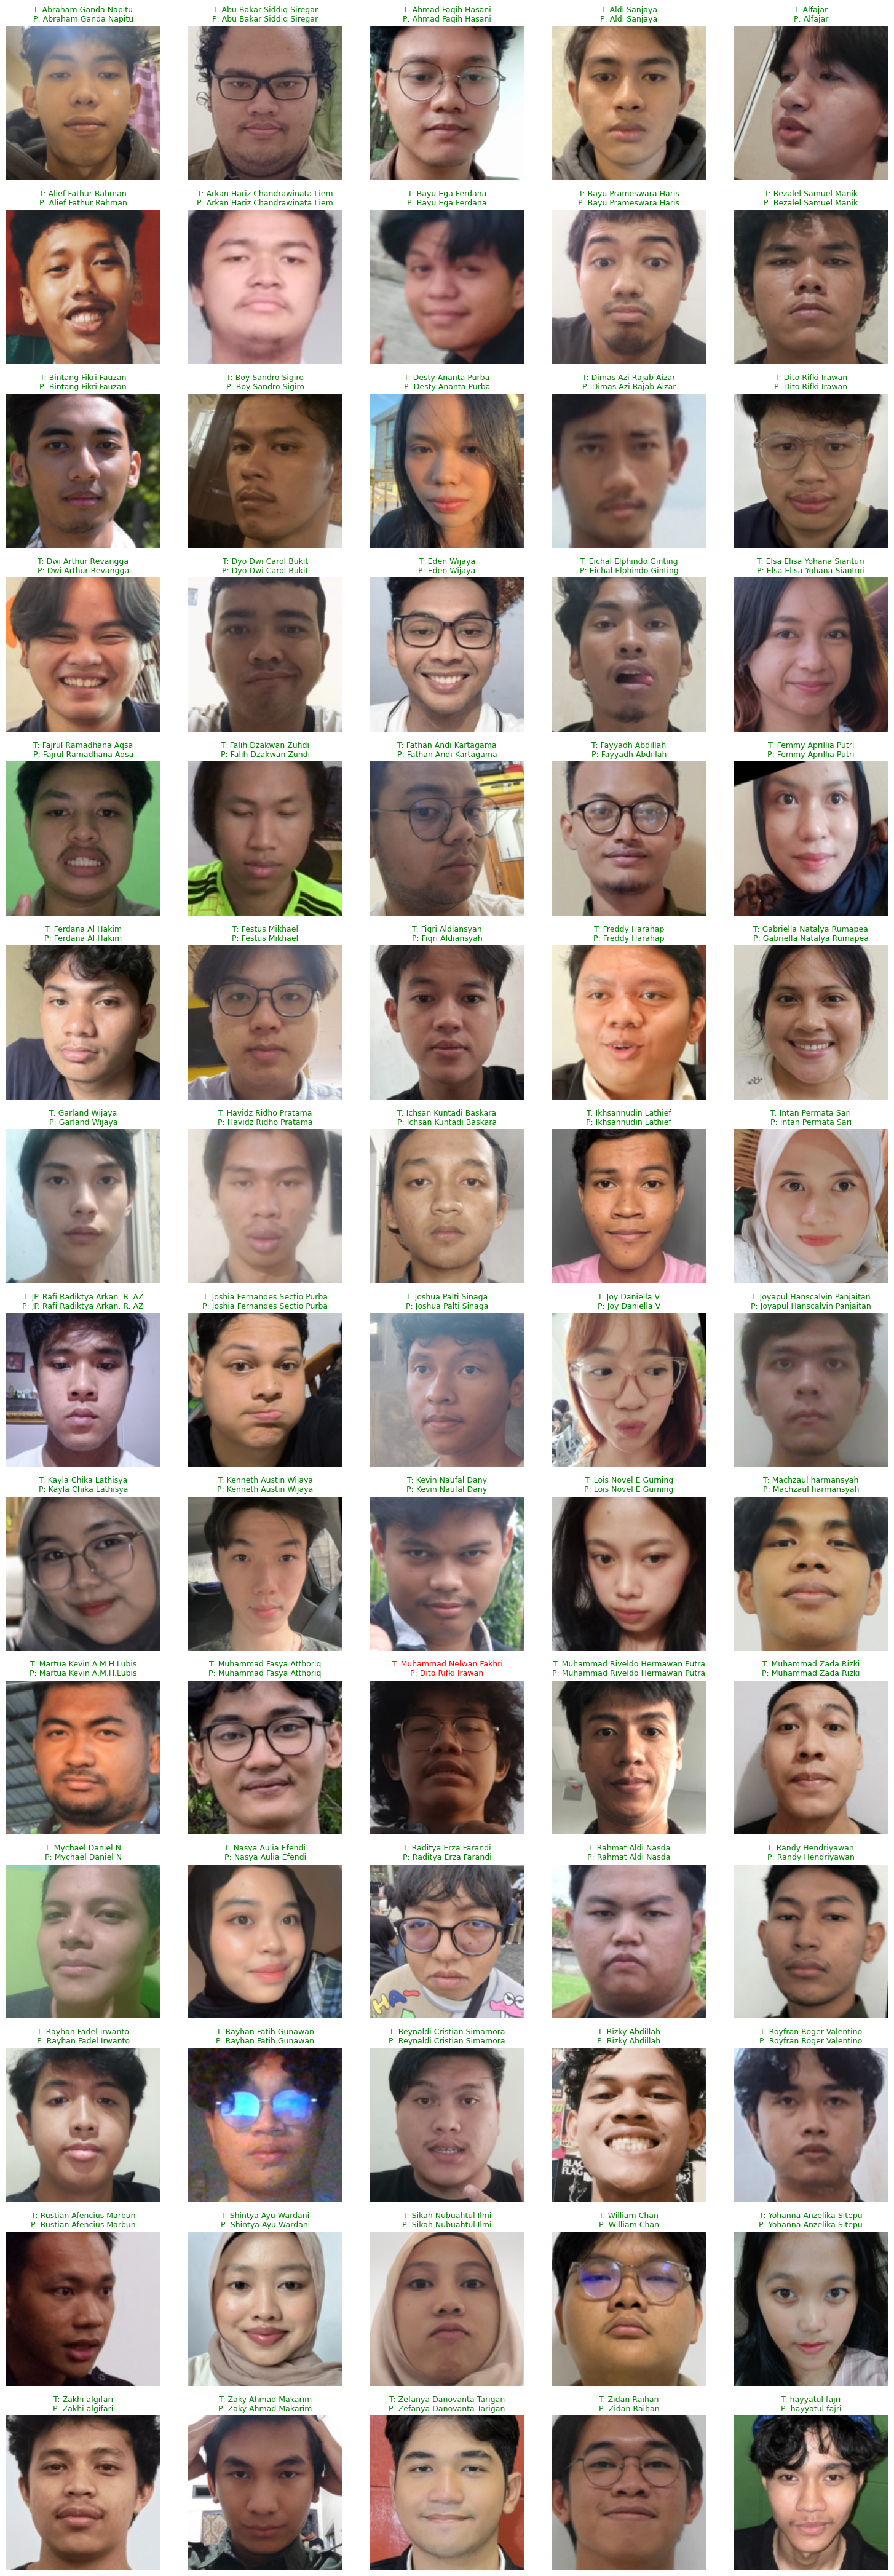

Displayed 70 images.


In [10]:
# ======================================================
# Cell 10 – Prediction Visualization
# ======================================================
import matplotlib.pyplot as plt

val_dataset = val_loader.dataset  # dari Cell 9
idx_to_class = {v: k for k, v in label_map.items()}

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T = torch.tensor(IMAGENET_STD).view(3, 1, 1)


def denormalize(img_t: torch.Tensor) -> np.ndarray:
    img = img_t.cpu() * IMAGENET_STD_T + IMAGENET_MEAN_T
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img


# --- Grid settings ---
ROWS = 14
COLS = 5
MAX_SHOW = 70

model.eval()
images_shown = 0

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Preview Predictions"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        for i in range(len(imgs)):
            if images_shown == 0:
                fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

            if images_shown >= MAX_SHOW:
                break

            r = images_shown // COLS
            c = images_shown % COLS
            ax = axes[r, c]

            img_np = denormalize(imgs[i])

            true_idx = labels[i].item()
            pred_idx = preds[i].item()

            true_name = idx_to_class[true_idx]
            pred_name = idx_to_class[pred_idx]
            correct = (true_idx == pred_idx)

            ax.imshow(img_np)
            ax.set_title(
                f"T: {true_name}\nP: {pred_name}",
                fontsize=9,
                color=("green" if correct else "red"),
            )
            ax.axis("off")

            for spine in ax.spines.values():
                spine.set_edgecolor("green" if correct else "red")
                spine.set_linewidth(3)

            images_shown += 1

        if images_shown >= MAX_SHOW:
            break

if images_shown > 0:
    plt.tight_layout()
    plt.show()

print(f"Displayed {images_shown} images.")
